# Part 1: Single subject classification (subject 1)
### Import required libraries

In [1]:
import pandas as pd
import seaborn as sns
sns.set()

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, SelectFromModel, RFE, mutual_info_classif
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from functions import *

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## 1.1. Visualize and preprocess the data
### Load and extract data

In [2]:
base_zip_path = extraction_dir = '../data/'
subject_num = 2
emg, stimulus, repetition = extract_and_load_mat_files(base_zip_path, extraction_dir, subject_num)

Dataset variables: dict_keys(['__header__', '__version__', '__globals__', 'subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition'])


### Exploration of the data

In [3]:
# Print the shape of the data and labels
print("EMG:", emg.shape)
print("Stimulus:", stimulus.shape)
print("Repetition:", repetition.shape)
print(f"There are {emg.shape[0]} timepoints and {emg.shape[1]} channels.")

n_stimuli = len(np.unique(stimulus)) - 1 # -1 because 0 is the resting condition
n_repetitions = len(np.unique(repetition)) - 1 # -1 because 0 is not a repetition
print(f'There are {n_stimuli} types of movement and {n_repetitions} repetitions.')

EMG: (100686, 10)
Stimulus: (100686, 1)
Repetition: (100686, 1)
There are 100686 timepoints and 10 channels.
There are 12 types of movement and 10 repetitions.


In [4]:
# How many samples (or timesteps) has each trial?
n_samples = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx  =np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1)
        n_samples[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))
n_samples

array([[307., 390., 262., 226., 418., 204., 196., 270., 306., 489.],
       [334., 323., 344., 309., 333., 376., 362., 307., 348., 339.],
       [465., 352., 450., 460., 436., 389., 323., 388., 383., 316.],
       [310., 402., 357., 396., 255., 333., 263., 369., 438., 471.],
       [516., 382., 425., 379., 463., 411., 387., 343., 286., 377.],
       [337., 319., 337., 368., 338., 336., 268., 354., 319., 313.],
       [428., 392., 341., 393., 421., 445., 342., 328., 329., 358.],
       [289., 372., 406., 397., 498., 336., 415., 328., 472., 405.],
       [384., 424., 371., 316., 280., 314., 342., 284., 307., 421.],
       [311., 296., 299., 296., 301., 246., 213., 317., 493., 221.],
       [352., 403., 338., 416., 330., 355., 313., 322., 329., 219.],
       [270., 330., 300., 387., 295., 204., 363., 267., 281., 329.]])

### Visualize raw EMG data

In [5]:
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

# Initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx  =np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg[idx, :]
        emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0)

/var/folders/q_/xhgs30s966s2xsy_tl8w2k680000gp/T/ipykernel_66580/1621191033.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', emg.shape[1]) # Define a color map


Text(0.5, 0.98, 'Envelopes of the EMG signal')

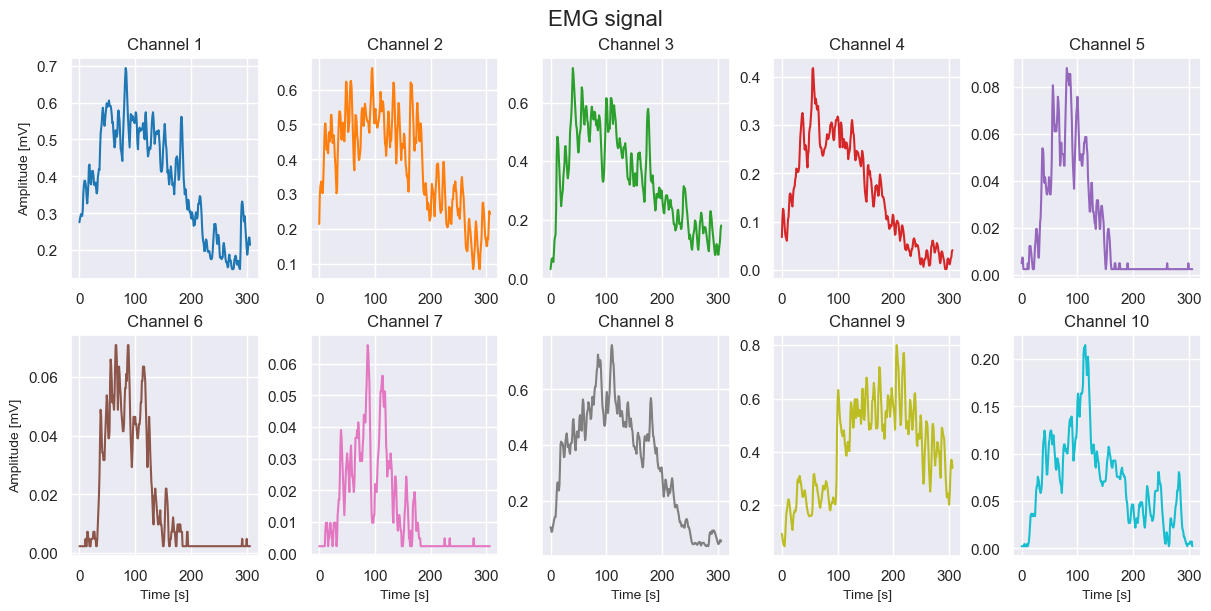

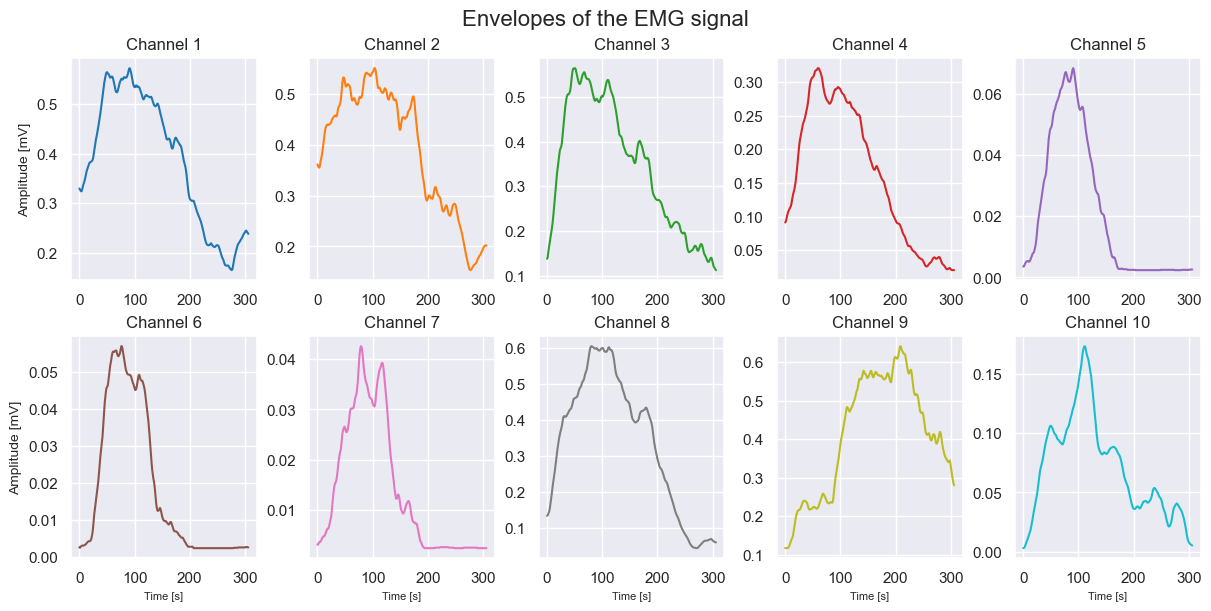

In [6]:
colors = plt.cm.get_cmap('tab10', emg.shape[1]) # Define a color map
n_channels = emg.shape[-1]

# EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout = True)
ax = ax.ravel()
for channel_idx in range(n_channels):
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx], color=colors(channel_idx))
    ax[channel_idx].set_title(f'Channel {channel_idx + 1}', fontsize=12)
    if channel_idx % 5 == 0:  # Leftmost column
        ax[channel_idx].set_ylabel("Amplitude [mV]", fontsize=10)
    if channel_idx >= 5:  # Bottom row
        ax[channel_idx].set_xlabel("Time [s]", fontsize=10)
plt.suptitle("EMG signal", fontsize=16)

# Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout = True)
ax = ax.ravel()
for channel_idx in range(n_channels):
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx], color=colors(channel_idx))
    ax[channel_idx].set_title(f'Channel {channel_idx + 1}', fontsize=12)
    if channel_idx % 5 == 0:  # Leftmost column
        ax[channel_idx].set_ylabel("Amplitude [mV]", fontsize=10)
    if channel_idx >= 5:  # Bottom row
        ax[channel_idx].set_xlabel("Time [s]", fontsize=8)
plt.suptitle("Envelopes of the EMG signal", fontsize=16)

To detect potential anomalies, we now want to plot all the channels with the same y axis:

Text(0.5, 0.98, 'EMG signal')

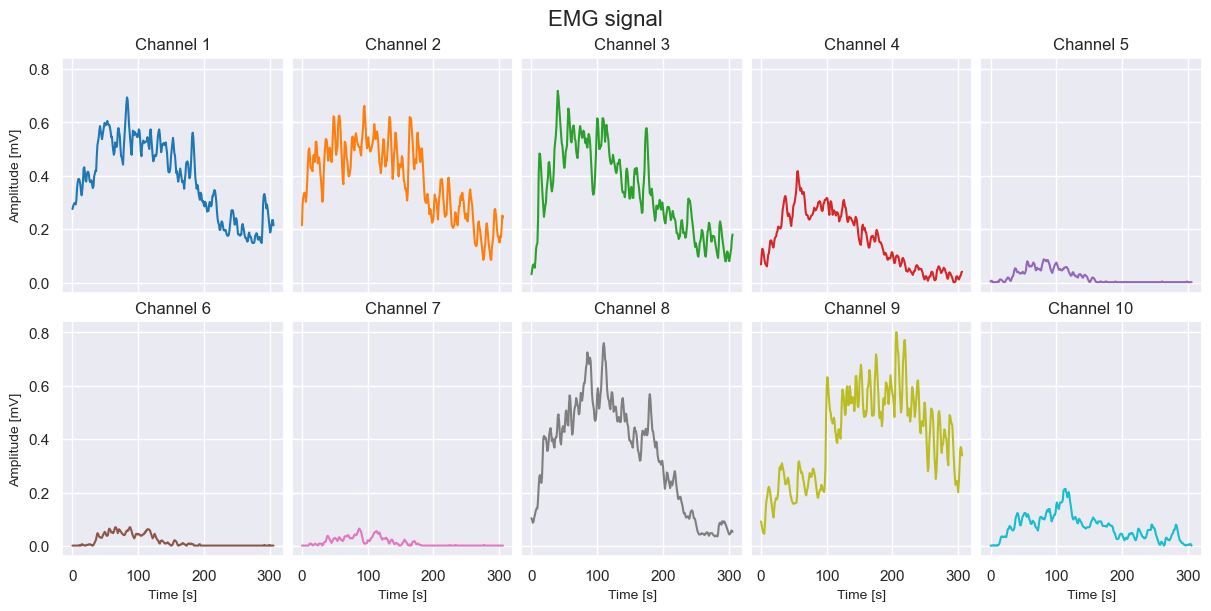

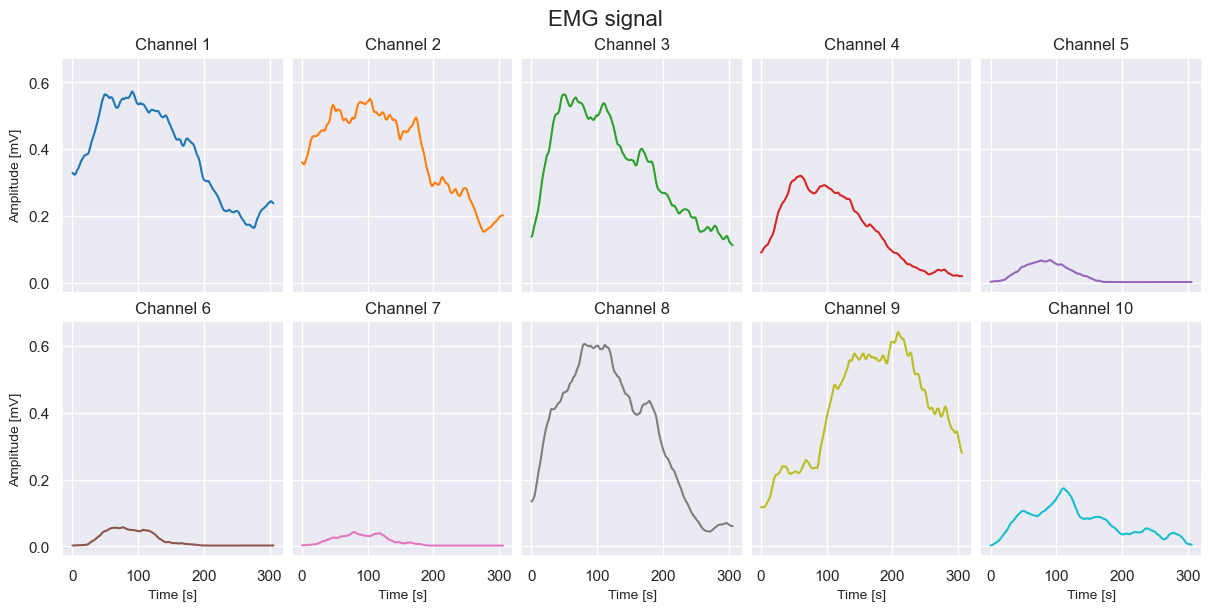

In [7]:
n_channels = emg.shape[-1]

# EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout = True, sharex=True, sharey=True)
ax = ax.ravel()
for channel_idx in range(n_channels):
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx], color=colors(channel_idx))
    ax[channel_idx].set_title(f'Channel {channel_idx + 1}', fontsize=12)
    if channel_idx % 5 == 0:  # Leftmost column
        ax[channel_idx].set_ylabel("Amplitude [mV]", fontsize=10)
    if channel_idx >= 5:  # Bottom row
        ax[channel_idx].set_xlabel("Time [s]", fontsize=10)
plt.suptitle("EMG signal", fontsize=16)

# Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout = True, sharex=True, sharey=True)
ax = ax.ravel()
for channel_idx in range(n_channels):
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx], color=colors(channel_idx))
    ax[channel_idx].set_title(f'Channel {channel_idx + 1}', fontsize=12)
    if channel_idx % 5 == 0:  # Leftmost column
        ax[channel_idx].set_ylabel("Amplitude [mV]", fontsize=10)
    if channel_idx >= 5:  # Bottom row
        ax[channel_idx].set_xlabel("Time [s]", fontsize=10)
plt.suptitle("EMG signal", fontsize=16)

The channels 1, 2, 3, 8 and 9 seem to have similar amplitudes, therefore we don't want to discard these channels, even though they might overpower the channels 5, 6 and 7.

### Visualization across repetitions

In [8]:
emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        # Mean across time
        emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0)

Text(0.5, 0.98, 'Stimulus for each EMG channel across repetitions')

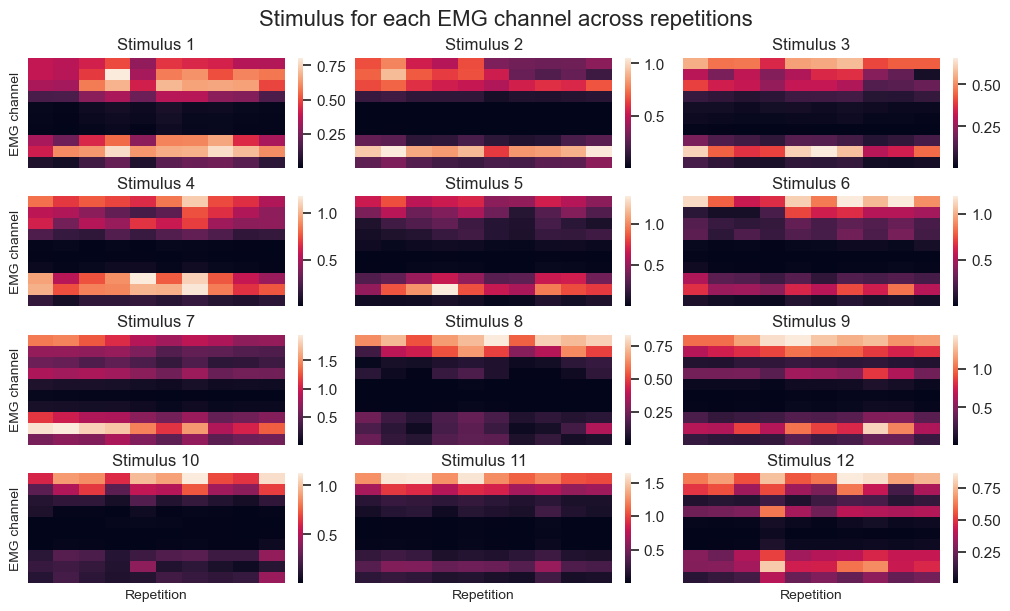

In [9]:
fig, ax = plt.subplots(4, 3, figsize=(10, 6), constrained_layout = True, sharex=True, sharey=True)
ax = ax.ravel()
for stimuli_idx in range(n_stimuli):
    sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax = ax[stimuli_idx], xticklabels=False, yticklabels=False, cbar = True)
    ax[stimuli_idx].set_title("Stimulus " + str(stimuli_idx + 1), fontsize=12)
    if stimuli_idx % 3 == 0:  # Leftmost column
        ax[stimuli_idx].set_ylabel("EMG channel", fontsize=10)
    if stimuli_idx >= 9:  # Bottom row
        ax[stimuli_idx].set_xlabel("Repetition", fontsize=10)
plt.suptitle("Stimulus for each EMG channel across repetitions", fontsize=16)

- Homogeneous by row: Each channel captures similar muscular activity across all 10 repetitions for a specific task, ensuring consistent data collection.

- Variability across columns: Different muscles (channels) show varied activation with each stimulus repetition due to physiological differences and impedance variations.

- Variability across stimuli: Different tasks activate different muscle groups, as seen in the distinct activation patterns across the 12 plots.

- Channels 5, 6, and 7 are overpowered: These channels have lower amplitudes but normalization isn't necessary as random forest algorithms can still extract patterns from low-amplitude channels.

### Preprocess EMG data

#### Bandpass filtering

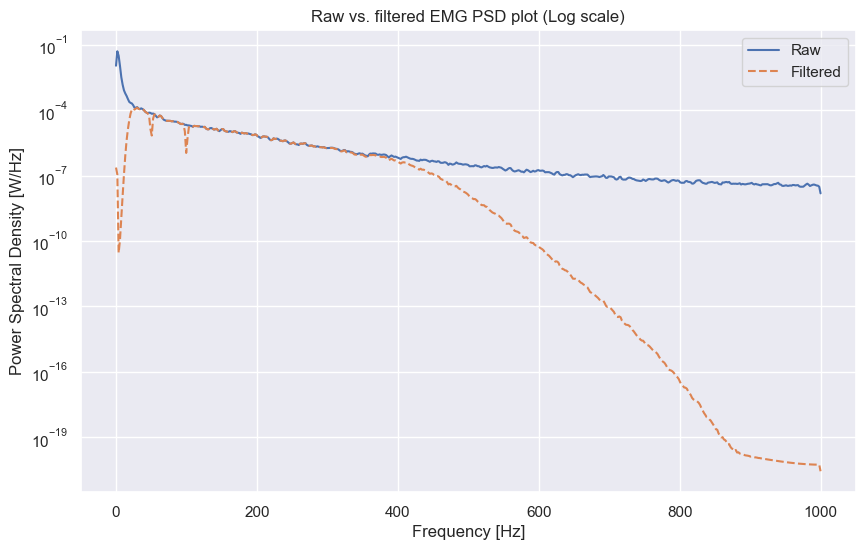

In [10]:
# Apply bandpass filter to the data
emg_filtered = bandpass_filter(emg)
fs = 2000.0 # Sampling frequency

# Plot the power spectrum of the first channel in log scale
freqs_pre, Pxx_pre = welch(emg[:, 0], fs, nperseg=1064)
freqs_post, Pxx_post = welch(emg_filtered[:, 0], fs, nperseg=1064)

# Plot the power spectrum in log scale
plt.figure(figsize=(10, 6))
plt.semilogy(freqs_pre, Pxx_pre, label="Raw")
plt.semilogy(freqs_post, Pxx_post, linestyle="--", label="Filtered")
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density [W/Hz]')
plt.title('Raw vs. filtered EMG PSD plot (Log scale)')
plt.show()

#### Rectify & envelop the signal

Text(0.5, 0.98, 'Envelopes of the EMG signal')

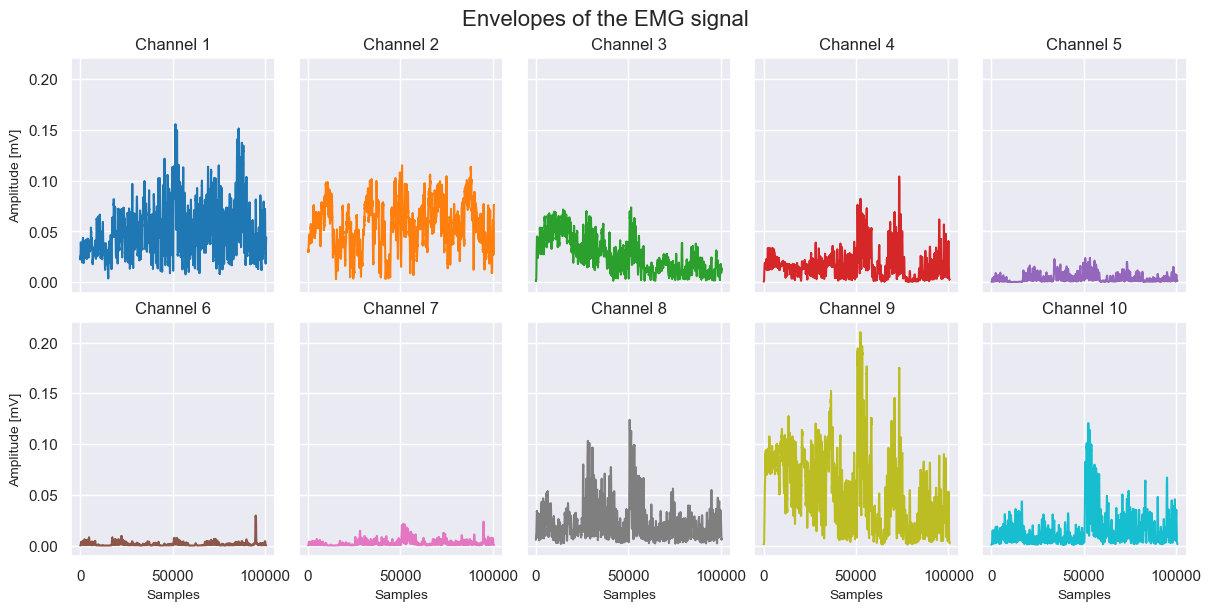

In [11]:
# Rectify the signal
emg_rectified = np.abs(emg_filtered)

# Envelop the signal using a moving average filter
mov_mean_size = 400
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size
emg_envelopes = convolve1d(emg_rectified, weights=mov_mean_weights, axis=0)

# Plot the envelope of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()
for channel_idx in range(n_channels):
    ax[channel_idx].plot(emg_envelopes[:, channel_idx], color=colors(channel_idx))
    ax[channel_idx].set_title(f'Channel {channel_idx + 1}', fontsize=12)
    if channel_idx % 5 == 0:  # Leftmost column
        ax[channel_idx].set_ylabel("Amplitude [mV]", fontsize=10)
    if channel_idx >= 5:  # Bottom row
        ax[channel_idx].set_xlabel("Samples", fontsize=10)
plt.suptitle("Envelopes of the EMG signal", fontsize=16)

**Question:** 

Does the data look reasonable? Did you need to remove any trials?

**Answer:** 

The data look reasonable, we did not remove any trials.

## 1.2. Split the data into training, validation, and testing sets

In [12]:
labels = stimulus

# Define the split ratio
train_ratio = 0.8
test_ratio = 0.2

# Split the data into training and test sets
data_train, data_test, labels_train, labels_test = train_test_split(emg, labels, test_size=test_ratio, random_state=42)

# Display the shapes of the datasets
data_info = {
    "Dataset": ["Training", "Testing"],
    "Data Shape": [data_train.shape, data_test.shape],
    "Labels Shape": [labels_train.shape, labels_test.shape]
}
df = pd.DataFrame(data_info)
print(df)

# Perform cross-validation with cv=5 when training the model
# Example: cross_validate(clf, data_train, labels_train, cv=5, scoring=scoring)

    Dataset   Data Shape Labels Shape
0  Training  (80548, 10)   (80548, 1)
1   Testing  (20138, 10)   (20138, 1)


**Question:** 

Why do we need the different datasets?

**Answer:** 

Different datasets are used to ensure a machine learning model generalizes well to new data. The training set is used to learn and adjust model parameters. The testing set provides an unbiased evaluation of the final model's performance on unseen data. During model training, cross-validation (e.g., with cv=5) is used to further split the training set into training and validation subsets. This helps tune hyperparameters and select the best model configuration. This approach ensures that the model is not just memorizing the training data but is able to generalize to new, unseen data, which is crucial for real-world applications.

## 1.3. Extract features from the trials

In [13]:
# Build the dataset and labels
dataset, labels = build_dataset_from_ninapro(
    emg=emg,
    stimulus=stimulus,
    repetition=repetition,
    features=[mav, std, maxav, rms, wl, ssc, dft_energy, median_frequency],
)

print(f"Dataset dimension: {dataset.shape}")
print(f"Labels dimension: {labels.shape}")

Dataset dimension: (120, 80)
Labels dimension: (120,)


### Look at the typical values of the features across the different trials

In [14]:
# Use the dataset in place of features
num_trials, num_features = dataset.shape
num_channels = emg.shape[1]  # Number of channels
num_feature_types = num_features // num_channels  # Number of feature types

# Generate feature names
feature_types = ['MAV', 'STD', 'MaxAV', 'RMS', 'WL', 'SSC', 'DFT_Energy', 'Median_Frequency']
feature_names = []
for i in range(num_channels):
    for feature_type in feature_types:
        feature_names.append(f'{feature_type}_{i+1}')

# Convert the dataset to a DataFrame for easier analysis
features_df = pd.DataFrame(dataset, columns=feature_names)

# Compute and print summary statistics
summary_stats = features_df.describe()
print(summary_stats)

            MAV_1       STD_1     MaxAV_1       RMS_1        WL_1       SSC_1  \
count  120.000000  120.000000  120.000000  120.000000  120.000000  120.000000   
mean     0.785619    0.334891    1.504780    0.857988    0.031928    0.329803   
std      0.320491    0.156158    0.633403    0.346767    0.010603    0.029624   
min      0.292367    0.066853    0.532200    0.323726    0.014448    0.259587   
25%      0.546918    0.200188    1.073575    0.590836    0.024182    0.309714   
50%      0.720820    0.334517    1.442850    0.801747    0.030539    0.329348   
75%      1.010312    0.433284    1.840225    1.088319    0.038243    0.346655   
max      1.640325    0.852318    3.864700    1.817505    0.063623    0.403743   

       DFT_Energy_1  Median_Frequency_1       MAV_2       STD_2  ...  \
count    120.000000          120.000000  120.000000  120.000000  ...   
mean     293.770296            0.034219    0.508316    0.204156  ...   
std      240.443483            0.015370    0.223031   

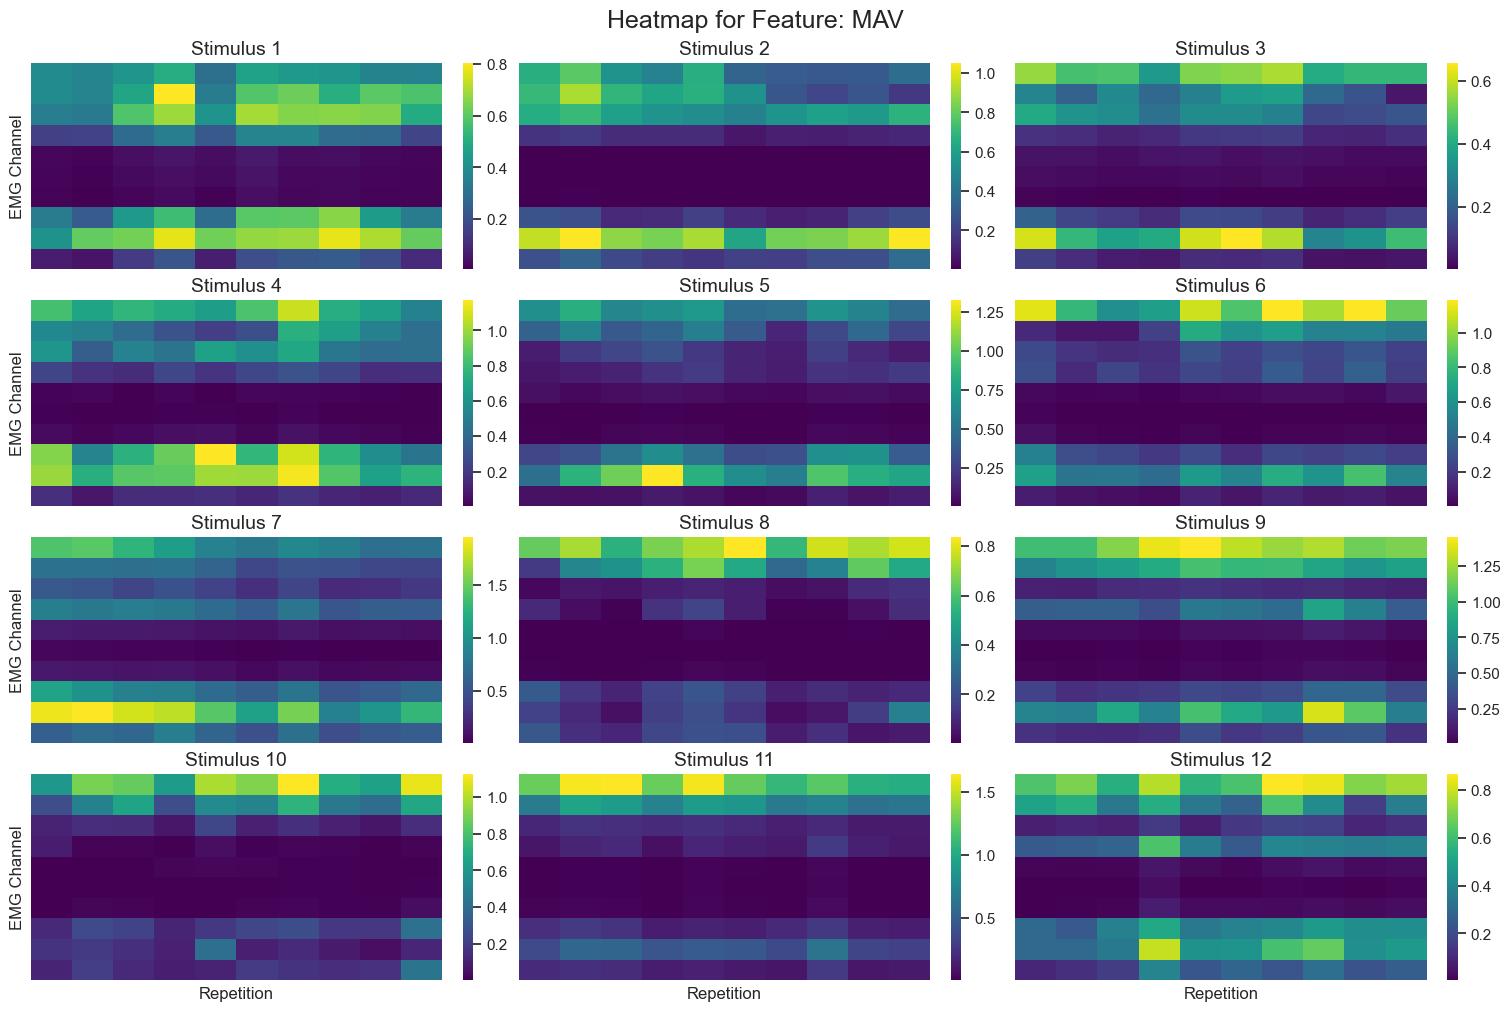

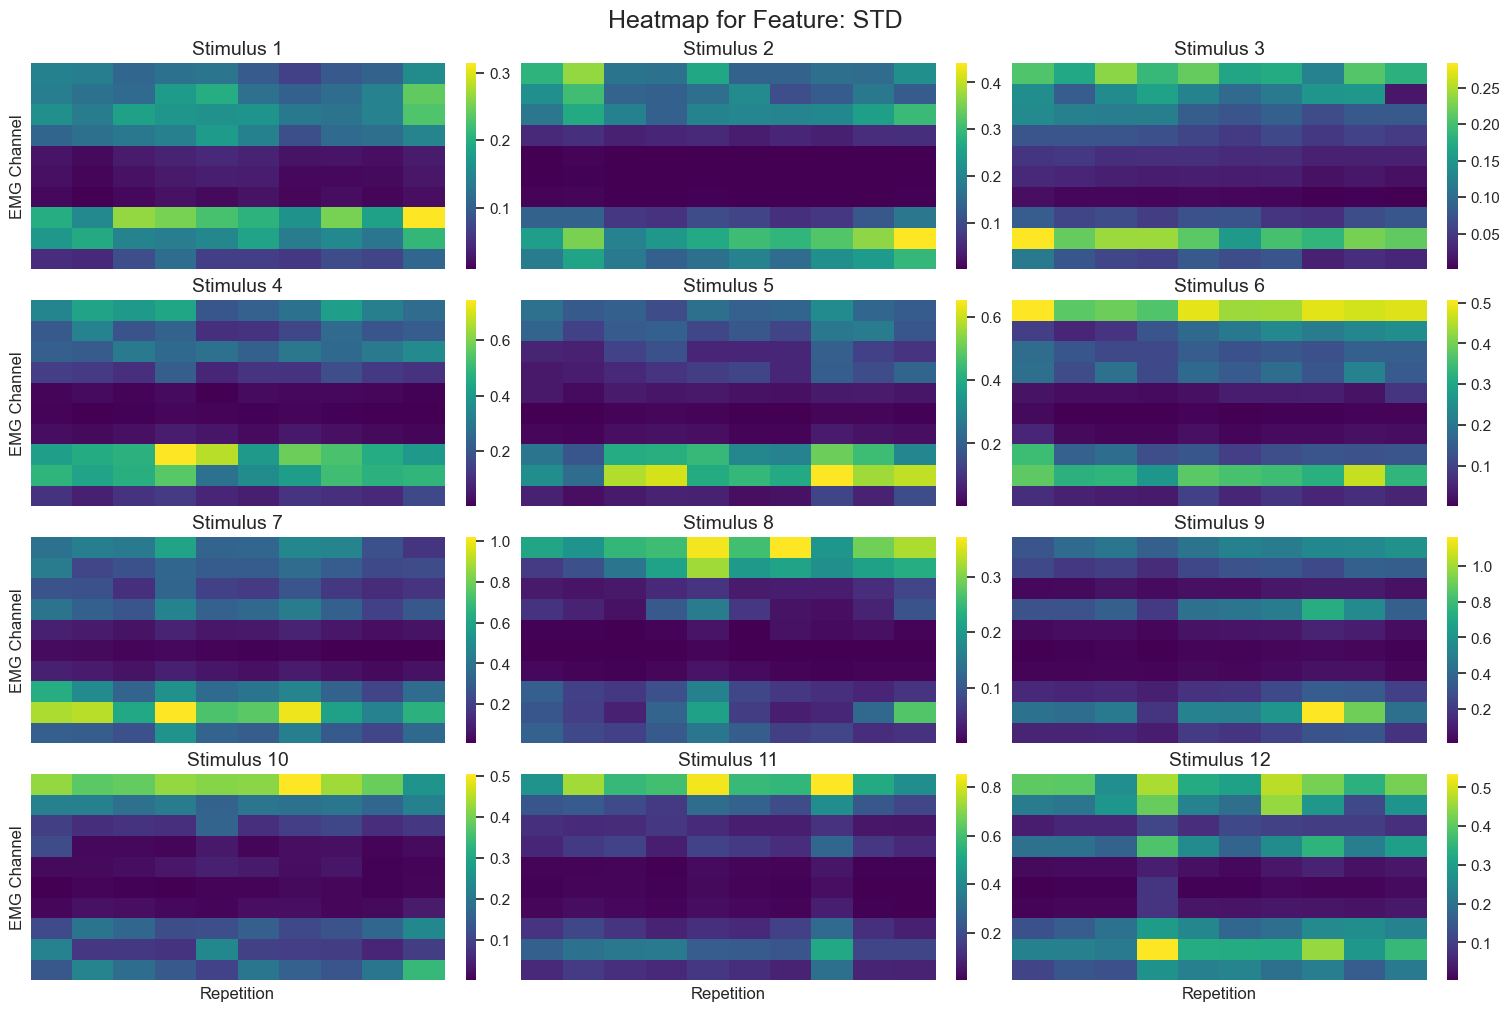

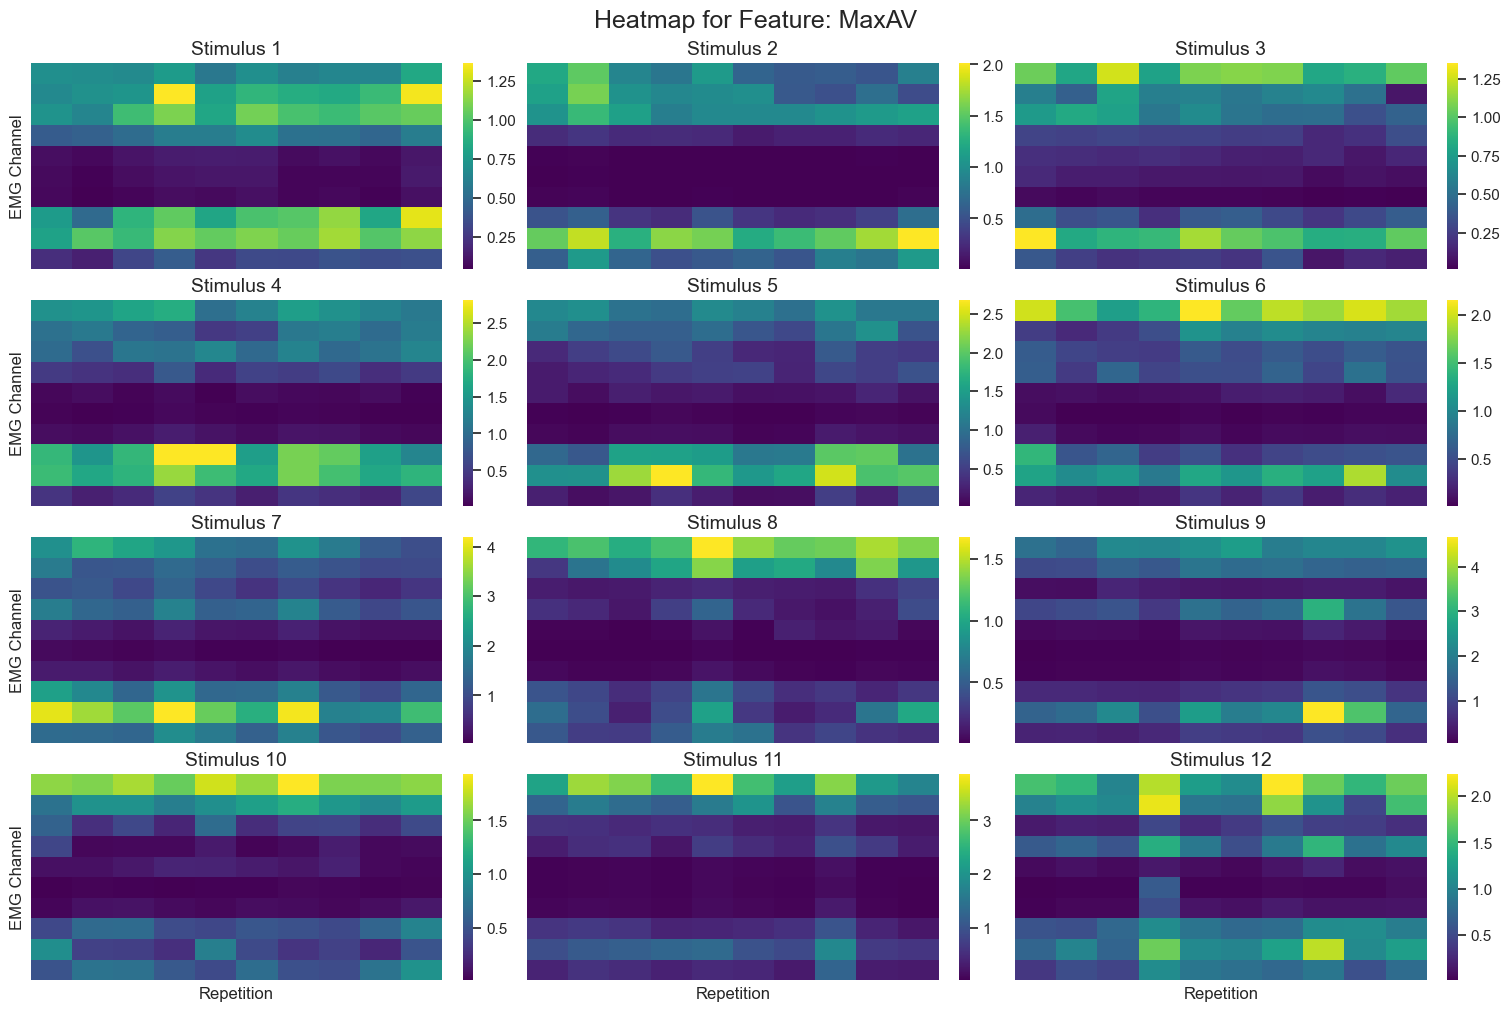

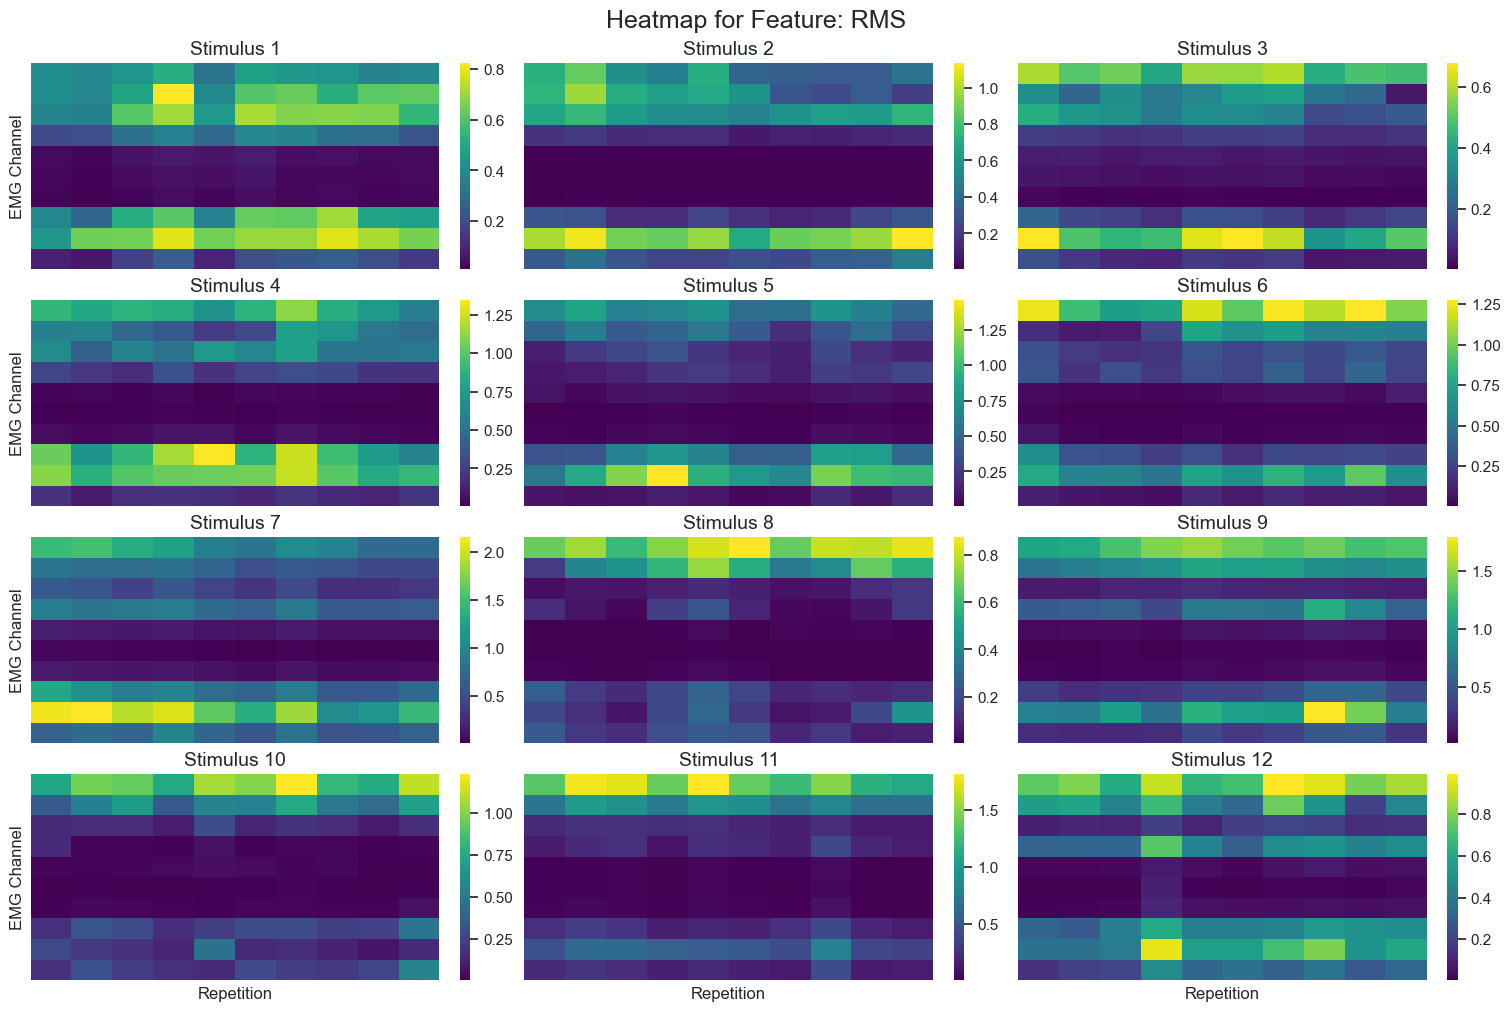

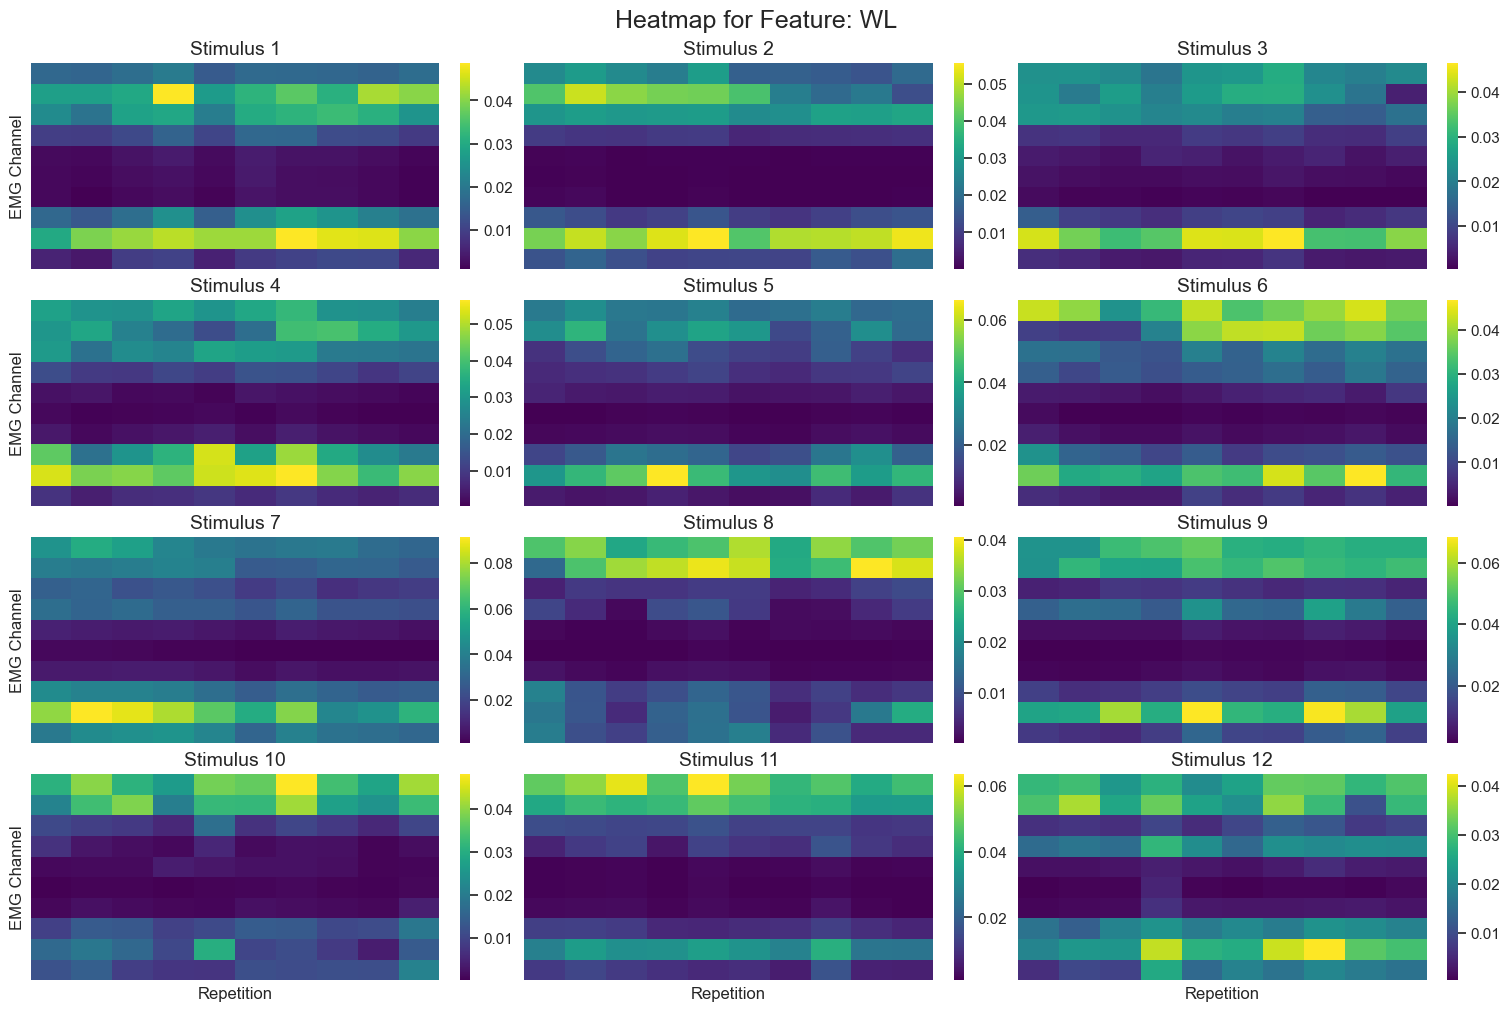

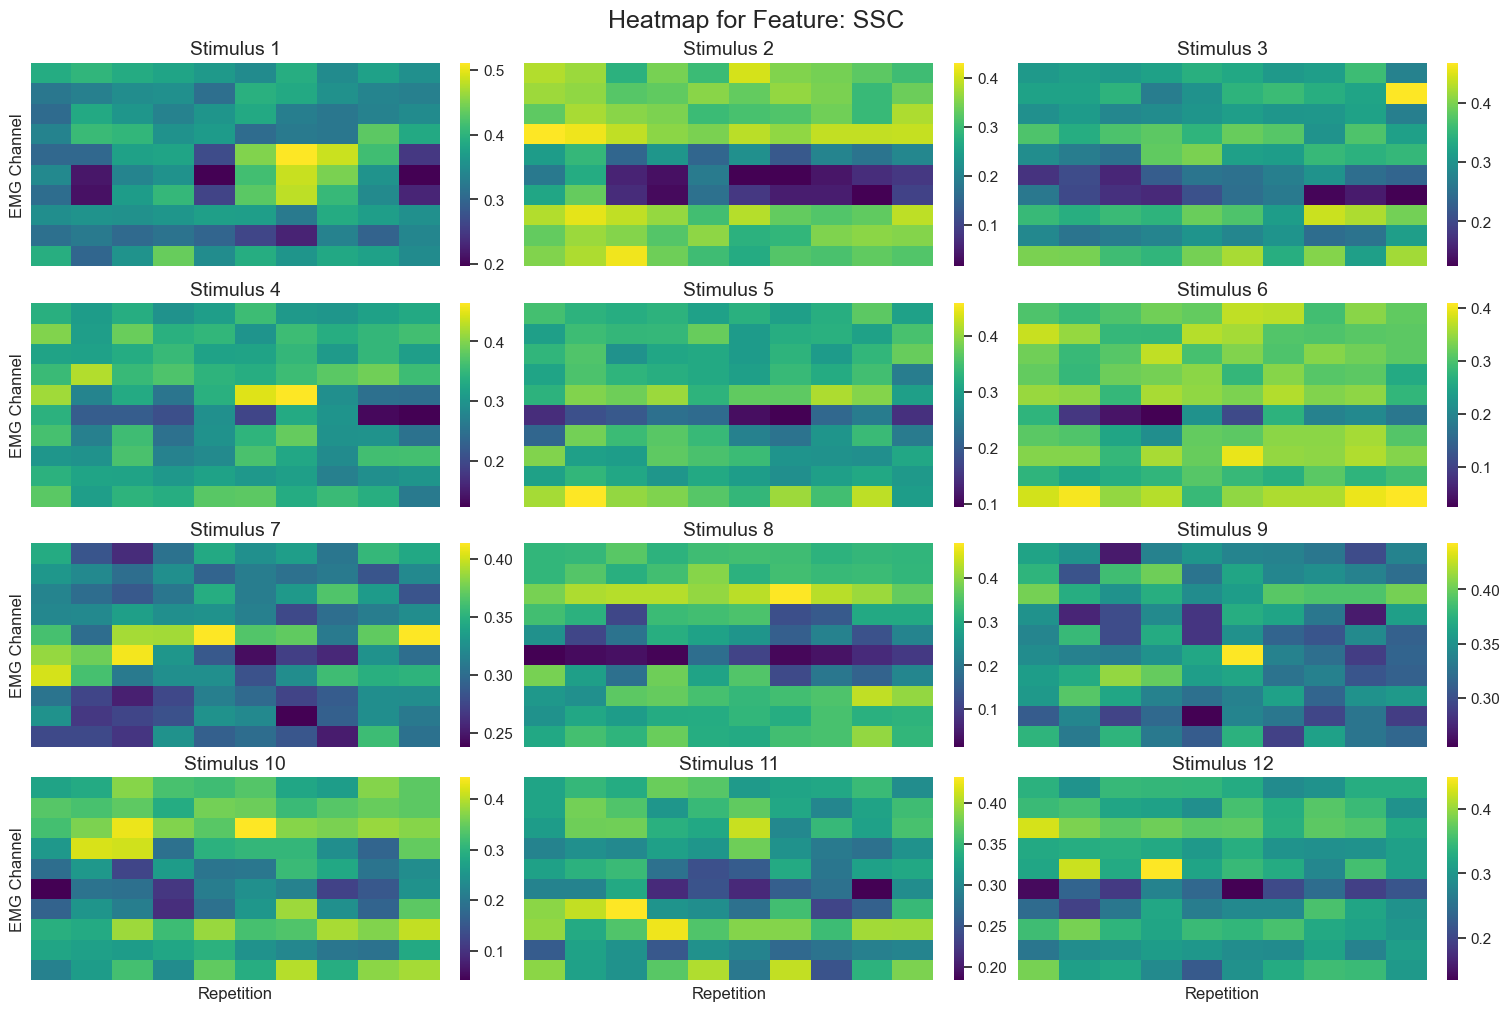

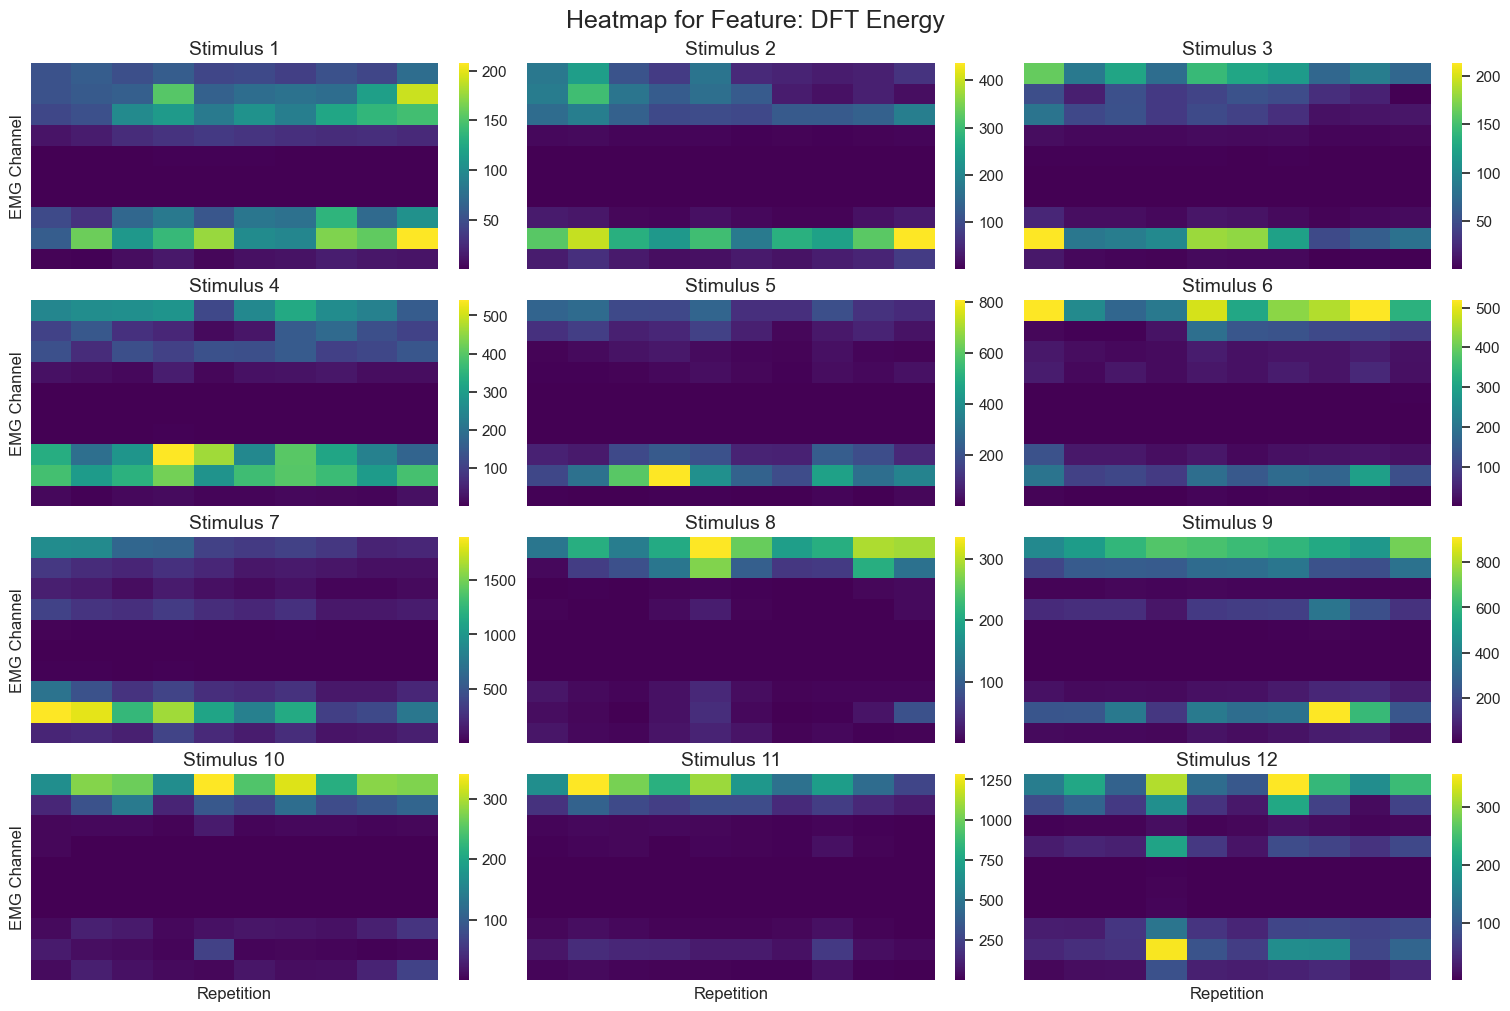

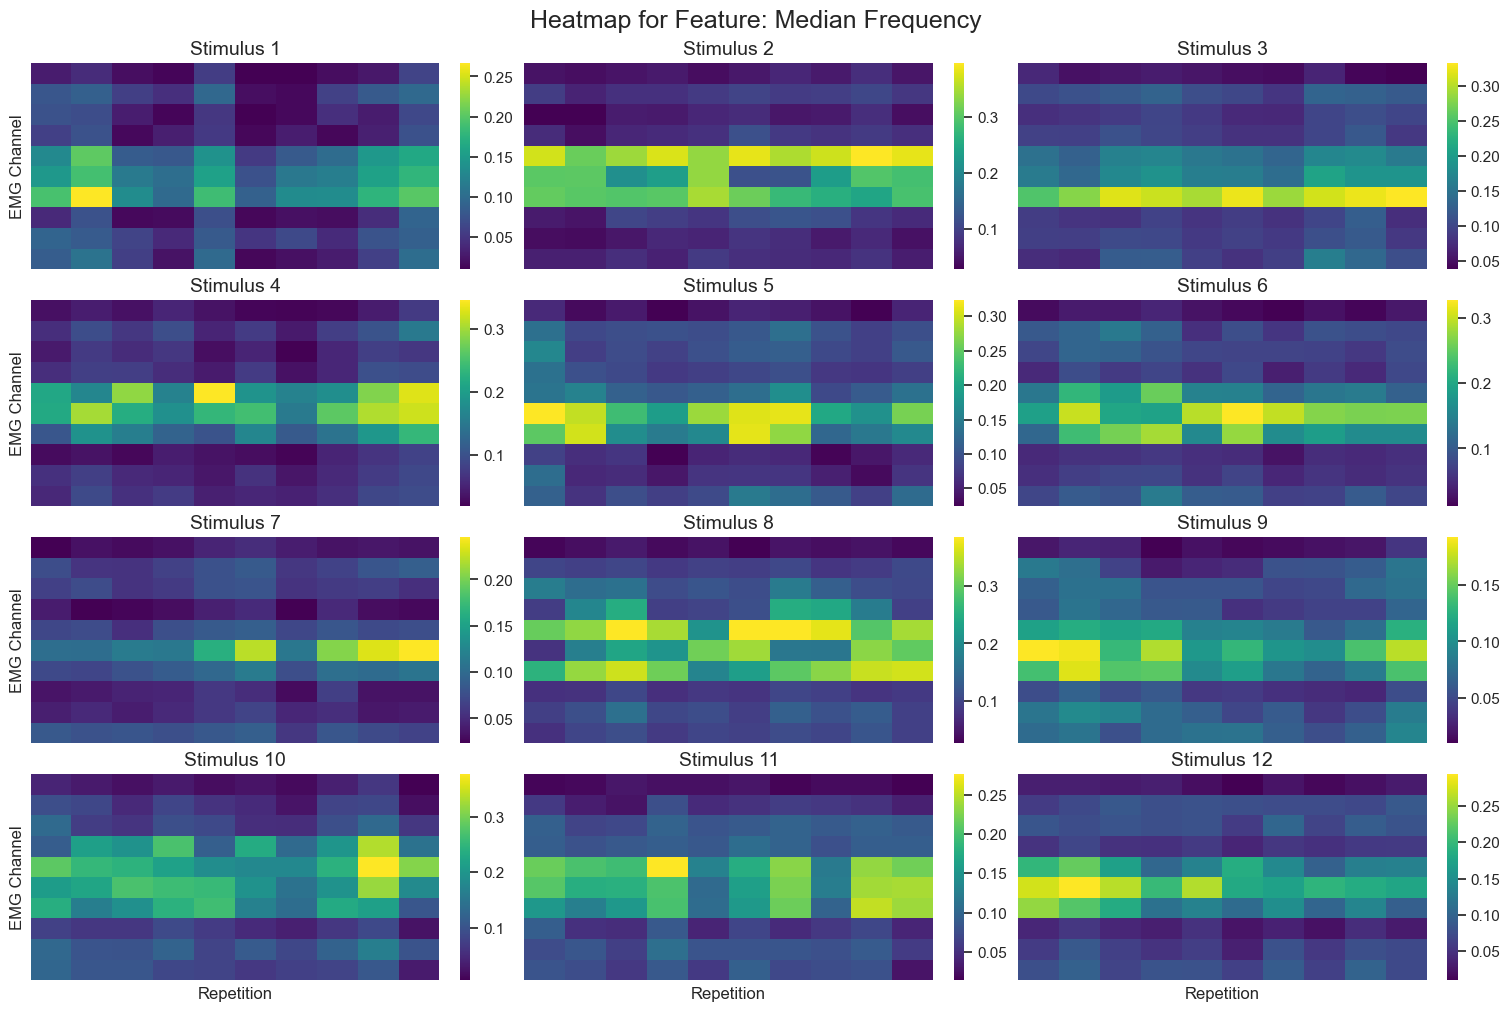

In [15]:
# Use the dataset in place of features
n_trials, n_features = dataset.shape
n_channels = emg.shape[1]  # Number of channels
n_feature_types = n_features // n_channels  # Number of feature types

# Reshape dataset into (num_trials, n_channels, n_features_types)
reshaped_dataset = dataset.reshape(n_trials, n_channels, n_feature_types)

# Generate feature names
feature_names = ['MAV', 'STD', 'MaxAV', 'RMS', 'WL', 'SSC', 'DFT Energy', 'Median Frequency']

# Plot heatmaps for each feature across stimuli
for feature_idx, feature_name in enumerate(feature_names):
    feature_data = reshaped_dataset[:, :, feature_idx]  # Shape (num_trials, num_channels)
    
    # Reshape to (n_stimuli, n_repetitions, num_channels)
    n_stimuli = len(np.unique(labels)) 
    n_repetitions = n_trials // n_stimuli
    feature_data = feature_data.reshape(n_stimuli, n_repetitions, num_channels)
    
    fig, ax = plt.subplots(4, 3, figsize=(15, 10), constrained_layout=True, sharex=True, sharey=True)
    ax = ax.ravel()

    for stimuli_idx in range(n_stimuli):
        sns.heatmap(
            np.transpose(feature_data[stimuli_idx, :, :]),  # Transpose to get channels on y-axis and repetitions on x-axis
            ax=ax[stimuli_idx],
            xticklabels=False,
            yticklabels=False,
            cbar=True,
            cmap="viridis"
        )
        ax[stimuli_idx].set_title(f'Stimulus {stimuli_idx + 1}', fontsize=14)
        if stimuli_idx % 3 == 0:  # Leftmost column
            ax[stimuli_idx].set_ylabel("EMG Channel", fontsize=12)
        if stimuli_idx >= 9:  # Bottom row
            ax[stimuli_idx].set_xlabel("Repetition", fontsize=12)
    plt.suptitle(f"Heatmap for Feature: {feature_name}", fontsize=18)

/var/folders/q_/xhgs30s966s2xsy_tl8w2k680000gp/T/ipykernel_66580/4267708113.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.errorbar(j, summary_stats.loc['mean'][index], yerr=summary_stats.loc['std'][index], fmt='o', ecolor=colors(j), capsize=5, label=f'Channel {j+1}' if i == 0 else "")
/var/folders/q_/xhgs30s966s2xsy_tl8w2k680000gp/T/ipykernel_66580/4267708113.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.errorbar(j, summary_stats.loc['mean'][index], yerr=summary_stats.loc['std'][index], fmt='o', ecolor=colors(j), capsize=5, label=f'Channel {j+1}' if i == 0 else "")
/var/folders/q_/xhgs30s966s2xsy_tl

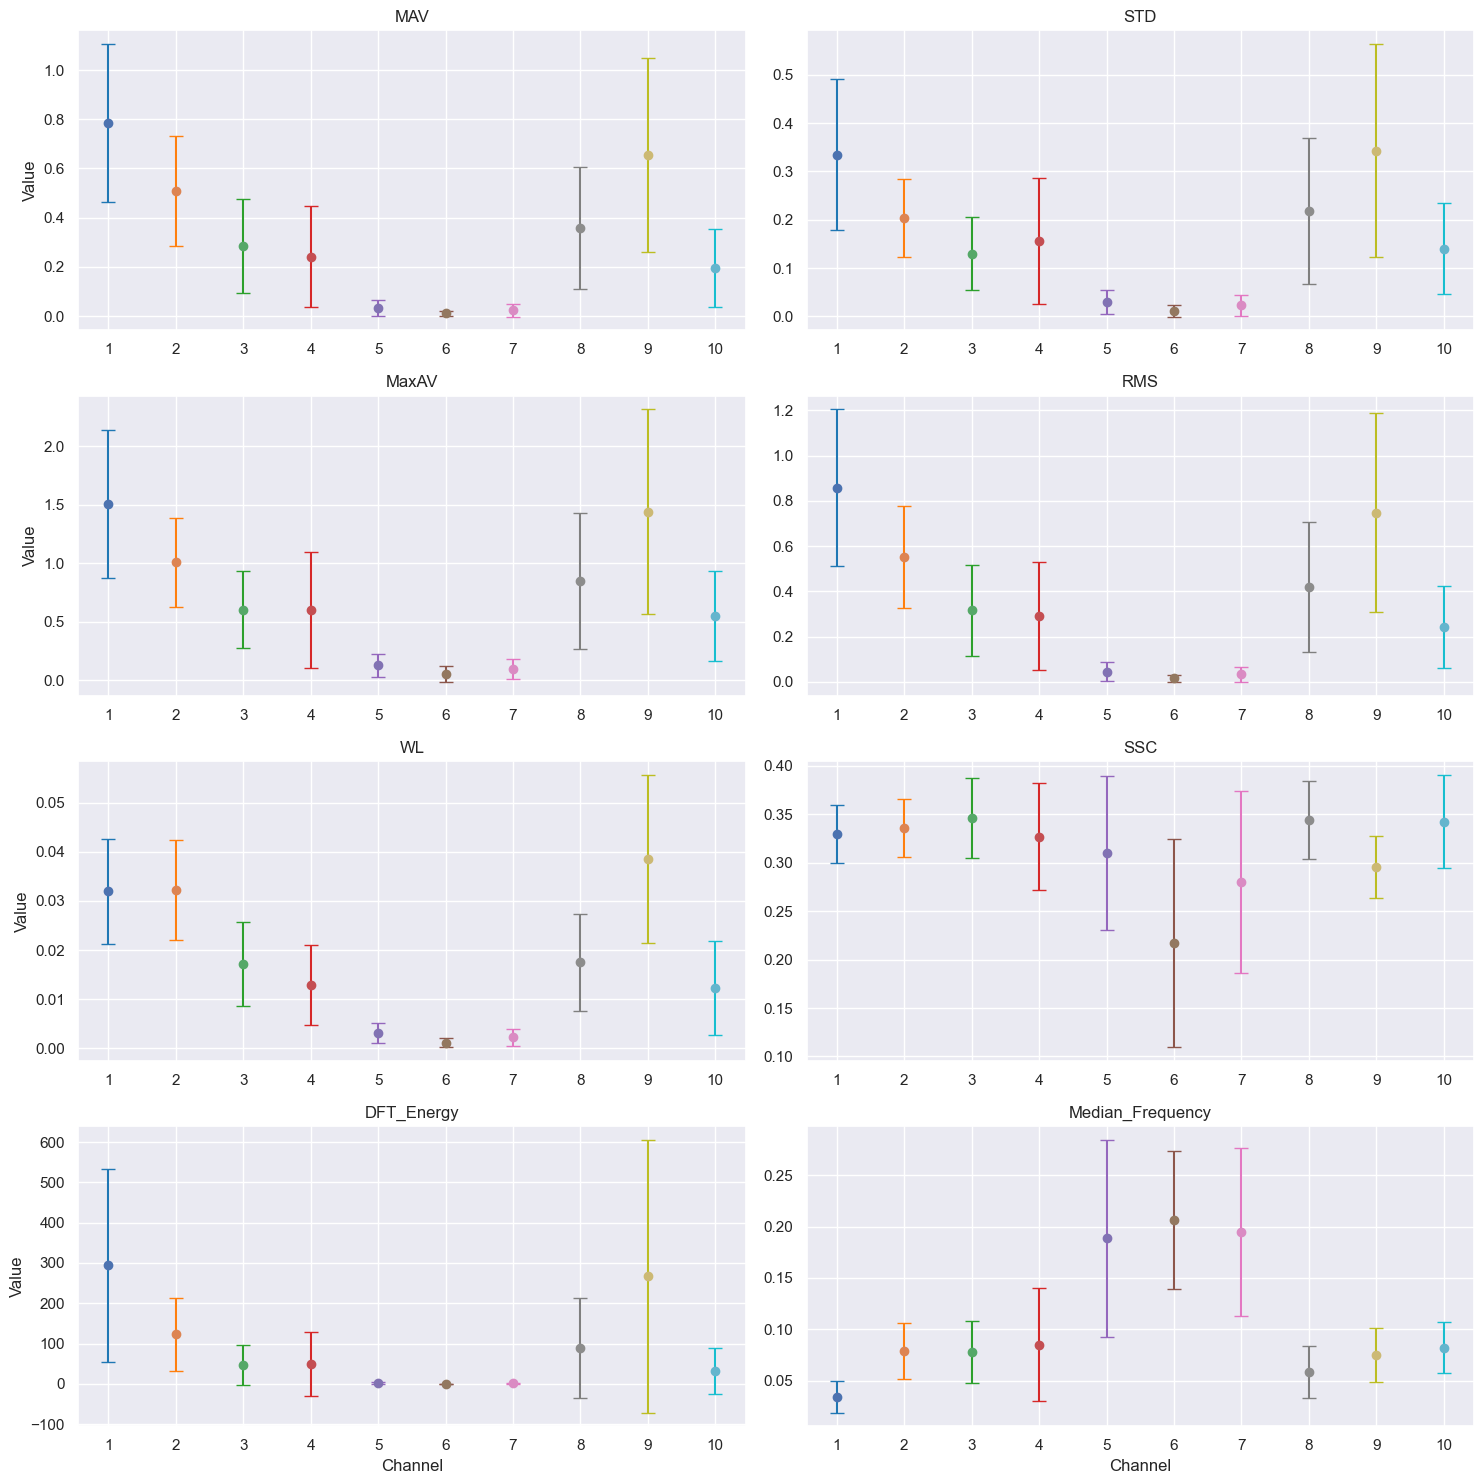

In [16]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
axes = axes.flatten()  # Flatten the 2D array of axes to make indexing easier

for i, feature_type in enumerate(feature_types):
    ax = axes[i]
    for j in range(num_channels):
        index = j * num_feature_types + i
        ax.errorbar(j, summary_stats.loc['mean'][index], yerr=summary_stats.loc['std'][index], fmt='o', ecolor=colors(j), capsize=5, label=f'Channel {j+1}' if i == 0 else "")
    ax.set_title(f'{feature_type}')
    if i % 2 == 0:  # Leftmost column
        ax.set_ylabel('Value')
    if i >= 6:  # Bottom row
        ax.set_xlabel('Channel')
    ax.set_xticks(range(num_channels))
    ax.set_xticklabels([j+1 for j in range(num_channels)])

plt.tight_layout()
plt.show()

**Question:** 

What do you see? Are the values similar between repetitions and between channels? Explain the possible reasons for similarity/discrepancies.

**Answer:** 

In most channels, we know that the values are similar between repetitions because the mean values of the features for each channel have relatively small standard deviations, as shown by the error bars in the plots, indicating a stable and repeatable EMG signals for the same movements. 

However, there are noticeable differences in feature values between channels. These discrepancies can be attributed to variations in electrode placement, differences in muscle activation, and impedance variations. These factors highlight the impact of physiological and technical factors on EMG signal characteristics.

## 1.4. Perform classification on the data (Random Forest)

In [17]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.3, random_state=42)

# Normalizing the data
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_test_z = scaler.transform(X_test)

# Train RandomForest classifier on the normalized data
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_z, y_train)

RandomForestClassifier(random_state=42)

## 1.5. Evaluate performance

F1 scores: [0.75098039 0.74117647 0.87254902 0.69467787 0.9375    ]
Mean F1 score: 0.79937675070028


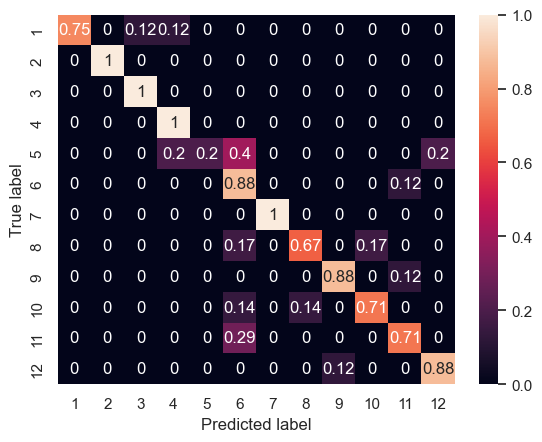

In [18]:
# Perform cross-validation and get predictions
y_pred_cv = cross_val_predict(clf, X_train_z, y_train, cv=5)

# Calculate the confusion matrix
confmat = confusion_matrix(y_train, y_pred_cv, normalize="true")

# Calculate the F1 score for each fold
f1_scores = cross_val_score(clf, X_train_z, y_train, cv=5, scoring='f1_weighted')

# Print the F1 scores
print(f"F1 scores: {f1_scores}")
print(f"Mean F1 score: {np.mean(f1_scores)}")

# Plot the confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
ax.set_xticklabels(range(1, len(confmat) + 1))
ax.set_yticklabels(range(1, len(confmat) + 1))
plt.show()

**Question:**

Justify why the metric is suitable for this task and whether the performance is satisfactory.

**Answer:**

The F1 score is suitable for this task as it balances precision and recall, making it ideal for imbalanced datasets. It provides a comprehensive evaluation by considering both false positives and false negatives. High and consistent F1 scores across cross-validation folds indicate satisfactory performance, showing the model generalizes well and maintains a good balance between precision and recall.

## 1.6. Feature selection & Dimension reduction

In [288]:
# Define the parameter grid for RandomForestClassifier
param_grid = {
    "n_estimators": [25, 50, 100],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False],
}

# Initialize GridSearchCV with RandomForestClassifier
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid)
grid.fit(X_train_z, y_train)

print(f"Best estimator: {grid.best_estimator_}")
print(f"Best hyperparameters: {grid.best_params_}")

Best estimator: RandomForestClassifier(min_samples_leaf=2, n_estimators=50, random_state=42)
Best hyperparameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


In [324]:
# Calculate mutual information between each feature and the target variable.
mutual_info = mutual_info_classif(X_train_z, y_train)
print(f"Estimated mutual information between each feature and the target:\n {mutual_info}\n")

# Select the top 30 features based on mutual information scores.
k_best = SelectKBest(mutual_info_classif, k=30)
k_best.fit(X_train_z, y_train)

# Transform the training and test datasets to only include the selected features.
X_train_best = k_best.transform(X_train_z)
X_test_best = k_best.transform(X_test_z)

# Train the RandomForestClassifier with the selected features.
clf_best = RandomForestClassifier(**grid.best_params_)  # Use the best parameters found before
clf_best.fit(X_train_best, y_train)

Estimated mutual information between each feature and the target:
 [0.66538039 0.81096066 0.88827185 0.73245715 0.80681771 0.10471612
 0.83112997 0.31887267 0.35555124 0.29820166 0.38801609 0.35529474
 0.29449022 0.05683047 0.28443253 0.43211932 0.80902596 0.74681621
 0.59979693 0.80644584 0.77123834 0.29773199 0.76589906 0.50803061
 1.0165986  0.84801206 0.79702339 0.9691871  0.89268143 0.31450183
 0.92881453 0.67313879 0.72613296 0.62323075 0.60521977 0.64237412
 0.69712133 0.5066084  0.59786332 0.81660645 0.48757237 0.53772448
 0.52537239 0.52058789 0.58821594 0.46877475 0.50700763 0.24159598
 0.55358948 0.59025214 0.52780814 0.56784132 0.57159659 0.48839238
 0.52082808 0.44700269 0.69433413 0.76960342 0.6896192  0.72078988
 0.7115142  0.29183817 0.7149604  0.58689418 0.74159534 0.89392984
 0.75579164 0.82532869 0.78464496 0.0186944  0.82584096 0.42596484
 0.69247141 0.57179228 0.62111706 0.6474963  0.73604666 0.23977292
 0.60013934 0.26405308]



RandomForestClassifier(min_samples_leaf=2, n_estimators=50)

F1 scores: [0.92156863 0.79019608 0.78431373 0.63333333 0.875     ]
Mean F1 score: 0.8008823529411764


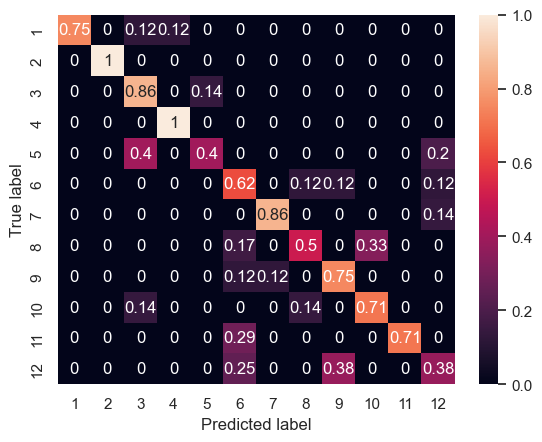

In [325]:
# Perform cross-validation and get predictions
y_pred_best_cv = cross_val_predict(clf_best, X_train_best, y_train, cv=5)

# Calculate the confusion matrix
confmat = confusion_matrix(y_train, y_pred_best_cv, normalize="true")

# Calculate the F1 score for each fold
f1_scores = cross_val_score(clf_best, X_train_best, y_train, cv=5, scoring='f1_weighted')

# Print the F1 scores
print(f"F1 scores: {f1_scores}")
print(f"Mean F1 score: {np.mean(f1_scores)}")

# Plot the confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
ax.set_xticklabels(range(1, len(confmat) + 1))
ax.set_yticklabels(range(1, len(confmat) + 1))
plt.show()

### Feature selection & Dimension reduction (other idea)

One could also apply other feature selection and dimension reduction methods to assess the accuracy and F1 score of our model:

In [266]:
# Perform L1-based feature selection using Logistic Regression
log_reg = LogisticRegression(C=1.0, penalty='l1', solver='liblinear', random_state=42)
log_reg.fit(X_train_z, y_train)

# Select features based on the L1 regularization
model = SelectFromModel(log_reg, prefit=True)
X_train_l1 = model.transform(X_train_z)
X_test_l1 = model.transform(X_test_z)

# Apply Recursive Feature Elimination (RFE) after L1 selection
rf_for_rfe = RandomForestClassifier(n_estimators=100, random_state=42)  # Base model for RFE
rfe = RFE(estimator=rf_for_rfe, n_features_to_select=30)  # Keep 30 features
rfe.fit(X_train_l1, y_train)

# Transform the data using RFE-selected features
X_train_rfe = rfe.transform(X_train_l1)
X_test_rfe = rfe.transform(X_test_l1)

# Perform PCA to reduce the dimensionality of the dataset
pca = PCA(n_components=20, random_state=42)  # Reduce to 10 principal components
X_train_pca = pca.fit_transform(X_train_rfe)
X_test_pca = pca.transform(X_test_rfe)

# Train the RandomForestClassifier with the PCA-transformed features
clf_combined = RandomForestClassifier(**grid.best_params_, random_state=42)
clf_combined.fit(X_train_pca, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=50, random_state=42)

F1 scores: [0.87254902 0.8        0.94117647 0.85882353 0.9375    ]
Mean F1 score: 0.8820098039215687


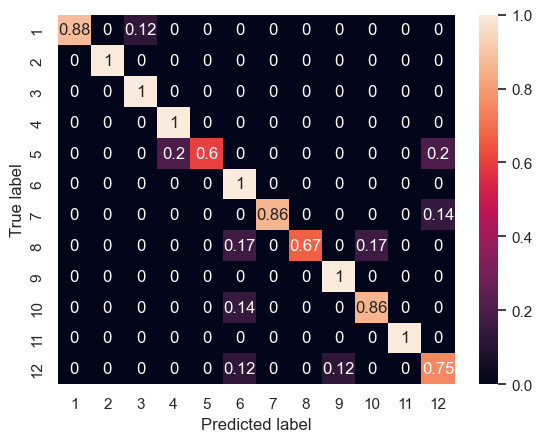

In [267]:
# Perform cross-validation and get predictions
y_pred_combined_cv = cross_val_predict(clf_combined, X_train_z, y_train, cv=5)

# Calculate the confusion matrix
confmat = confusion_matrix(y_train, y_pred_combined_cv, normalize="true")

# Calculate the F1 score for each fold
f1_scores = cross_val_score(clf_combined, X_train_z, y_train, cv=5, scoring='f1_weighted')

# Print the F1 scores
print(f"F1 scores: {f1_scores}")
print(f"Mean F1 score: {np.mean(f1_scores)}")

# Plot the confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
ax.set_xticklabels(range(1, len(confmat) + 1))
ax.set_yticklabels(range(1, len(confmat) + 1))
plt.show()

**Question:**

Evaluate the performance using the same metric as point 5. Is there an improvement in the performance?

**Answer:**

We go from a mean F1 score of 0.7993 for the original classifier to a mean F1 score of 0.8009 for the classification model that went through feature selection and dimension reduction, hence there is no real improvement in performance from the former to the latter.

However, we can improve the model using other techniques like L1-based feature selection and Recursive Feature Elimination (RFE), as well as Principal Component Analysis (PCA) for dimension reduction, yielding a solid mean F1 score of 0.8820.